#Reinfrocement Learning Workshop Part 1
---

## Imports & Installs

In [1]:
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py
!pip install gym==0.17.2 > /dev/null 2>&1
!pip install pyvirtualdisplay==1.3.2 > /dev/null 2>&1

     |████████████████████████████████| 450kB 2.8MB/s 


In [2]:
%matplotlib inline

In [3]:
import gym
import glob
import base64
import io
import os
import sys
import tqdm
import numpy as np
from collections import namedtuple, deque
import random
import torch
import time
import pandas as pd
import seaborn as sns
from torch.distributions import Categorical
from collections import defaultdict
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
import pyvirtualdisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from IPython.display import HTML
from collections import namedtuple, deque

In [4]:
# Setup of xvfb display server wrapper.
display = Display(visible=0, size=(400, 300))
display.start()
os.environ.get("DISPLAY")

':0'

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video(path_prefix='/video/'):
  mp4list = glob.glob(f'{path_prefix}*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    fmt = 'ascii'
    ipythondisplay.display(HTML(
        data=f'<video alt="recording" autoplay loop controls style="height: 400px;">\
               <source src="data:video/mp4;base64,{encoded.decode(fmt)}" type="video/mp4"/>\
               </video>'))
  else: 
    print("Could not find video")
    

def wrap_env(env, path_prefix='/video/'):
  env = Monitor(env, path_prefix, force=True)
  return env

In [6]:
# Mounting gdrive..

from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/ml_college_data'
!mkdir '/content/drive/My Drive/ml_college_data/rl_workshop/'
rl_workshop_path = '/content/drive/My Drive/ml_college_data/rl_workshop/'


Mounted at /content/drive
dataset_ceos	       imagenet_category_names.json  rl_workshop
dataset_fashion_mnist  models
mkdir: cannot create directory ‘/content/drive/My Drive/ml_college_data/rl_workshop/’: File exists


## OpenAI Gym
 - introduction of OpenAI gym environment
 - exploring simple and more complex environments
 - how to visualize game play

All environments has it's leaderboards and defined success scores: https://github.com/openai/gym/wiki/Leaderboard#

In [ ]:
np.random.choice(list(gym.envs.registry.all()), 5)

array([EnvSpec(BreakoutNoFrameskip-v4), EnvSpec(Venture-ram-v0),
       EnvSpec(CrazyClimber-v4), EnvSpec(HalfCheetah-v2),
       EnvSpec(Asterix-v4)], dtype=object)

#### Simple text based environment exploration

Text environment with fully observable state space. More details can be found at https://gym.openai.com/envs/FrozenLake-v0/



In [ ]:
# Creating and resetting of the gym environment..
game = "FrozenLake8x8-v0"
env = gym.make(game)
state = env.reset()
screen = env.render(mode='ansi')
print(screen)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [ ]:
env.observation_space.n

64

In [ ]:
np.arange(64).reshape((8, 8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [ ]:
env.action_space.n

4

In [ ]:
env.action_space.sample()

3

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [ ]:
state = 50
action = RIGHT
env.env.P[state][action]

[(0.3333333333333333, 58, 0.0, False),
 (0.3333333333333333, 51, 0.0, False),
 (0.3333333333333333, 42, 0.0, True)]

In [ ]:
# Exploration of non-deterministic behaviour of environment.
next_state, reward, done, info = env.step(action)
screen = env.render(mode='ansi')
print(screen)
print('Action:', action)
print('Next state:', next_state)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Action: 2
Next state: 29
Reward: 0
Done: True
Info: {'prob': 1.0}


In [ ]:
# Game play.

# Setup of environment.
game = "FrozenLake8x8-v0"
env = gym.make(game)
state = env.reset()

for iteration in range(100):
  # Sampling random action.
  action = env.action_space.sample()
  # Applying action in the envrinment.
  next_state, reward, done, info = env.step(action)
  # Clearing up the screen.
  ipythondisplay.clear_output(wait=True)
  screen = env.render('ansi')
  print(screen)
  print()
  print('Action', action)
  print('Obs', next_state)
  print('Reward', reward)
  print('Done', done)
  print('Info', info)
  time.sleep(0.3)
  if done:
    print(f"Agent end up in {iteration} iterations.")
    break
env.close()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2
Obs 29
Reward 0.0
Done True
Info {'prob': 0.3333333333333333}
Agent end up in 24 iterations


#### Complex Atari environment
Not fully observable environment of Pacman (https://gym.openai.com/envs/MsPacman-v0/) with even more rich domain of actions and states.

In [ ]:
env = gym.make("MsPacman-v0")

In [ ]:
env.observation_space

Box(210, 160, 3)

In [ ]:
env.action_space.n

9

In [ ]:
env.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [ ]:
state = env.reset()
state.shape

(210, 160, 3)

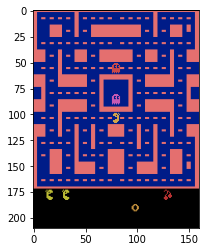

In [ ]:
fig = plt.imshow(env.render('rgb_array'))

In [ ]:
env = wrap_env(gym.make("MsPacman-v0"), '/video/pacman/')
state = env.reset()
while True:
    # 'human' type of rendenring is suitable when we do the recording
    env.render('human')
    action = env.action_space.sample()      
    next_state, reward, done, info = env.step(action) 
    if done: 
      break;   
env.close()

In [ ]:
show_video('/video/pacman/')

Explore other environments, eg. https://gym.openai.com/envs/CartPole-v1/. There is always a link to actual code of environment to check details about behaviour etc..

## Model Based Methods
 - revisit of frozen lake environment
 - policy evaluation in the fully observable environment
 - policy improvement and interation
 - visualization of the V and action space

#### Frozen Lake revisited

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="4x4", is_slippery=True)

In [ ]:
env.action_space.n

4

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

policy_mapping = {
    0: "LEFT",
    1: "DOWN",
    2: "RIGHT",
    3: "UP"
}

In [ ]:
env.observation_space.n

16

In [ ]:
state = 10
env.P[state][LEFT]

[(0.3333333333333333, 6, 0.0, False),
 (0.3333333333333333, 9, 0.0, False),
 (0.3333333333333333, 14, 0.0, False)]

In [ ]:
prob, next_state, reward, done = env.env.P[state][LEFT][0]
prob, next_state, reward, done

(0.3333333333333333, 6, 0.0, False)

In [ ]:
# Comparison of non deterministic and deterministic environment
env = gym.make(game, map_name="4x4", is_slippery=False)
state = 10
env.P[state][LEFT]

[(1.0, 9, 0.0, False)]

#### Policy evaluation

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="4x4", is_slippery=False)
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

In [ ]:
def policy_evaluation(policy, env, gamma=0.9, improvement=1e-8):
  """ Applies policy to environment and collects results to build value function.
      
      Params:
        policy: np.array([states, actions]).
        env: OpneAI envirnment.
        gamma: Discount of future rewards.
        improvements: Minimal improvement of V to continue evaluation.
      Return: Value function.
  """

  V = np.zeros(env.observation_space.n)

  while True:
    # Record biggest single iteration improvement.
    delta = 0
    # Iterate over all states, actions and env responses to actions.
    for state in range(env.observation_space.n):
      v_s = 0
      ################################################
      #  Use env.P to calculate value for each state #
      ################################################
      # Keep information about biggest improvement.
      delta = max(delta, np.abs(V[state] - v_s))
      V[state] = v_s
    if delta < improvement:
      break
  return V

In [ ]:
# Test your policy evaluation method
game = "FrozenLake-v0"
env = gym.make(game, map_name="4x4", is_slippery=False)
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V_expected = np.array([0.0045, 0.0042, 0.0101, 0.0041, 0.0067, 0., 0.0263, 0., 0.0187, 0.0576, 0.107, 0., 0., 0.1304, 0.3915, 0.])
np.testing.assert_array_equal(V_expected, policy_evaluation(policy, env, gamma=0.9, improvement=1e-8).round(4))

In [ ]:
def policy_evaluation(policy, env, gamma=0.9, improvement=1e-8):
  """ Applies policy to environment and collects results to build value function.
      
      Params:
        policy: np.array([states, actions]).
        env: OpneAI envirnment.
        gamma: Discount of future rewards.
        improvements: Minimal improvement of V to continue evaluation.
      Return: Value function.
  """

  V = np.zeros(env.observation_space.n)

  while True:
    # Record biggest single iteration improvement.
    delta = 0
    # Iterate over all states, actions and env responses to actions.
    for state in range(env.observation_space.n):
      v_s = 0
      for action in env.P[state].keys():
        for prob, next_state, reward, done in env.P[state][action]:
          v_s += policy[state][action] * prob * (reward + gamma * V[next_state])
      # Keep information about biggest improvement.
      delta = max(delta, np.abs(V[state] - v_s))
      V[state] = v_s
    if delta < improvement:
      break
  return V

In [ ]:
V = policy_evaluation(policy, env, gamma=0.9, improvement=1e-8)

In [ ]:
def visualize_V(V, shape, figsize=(10, 10)):
  V_df = pd.DataFrame(V.reshape(shape))
  plt.figure(figsize=figsize)
  fig = sns.heatmap(V_df, annot=True, linewidths=.5, cmap='Blues',  xticklabels=False, yticklabels=False)

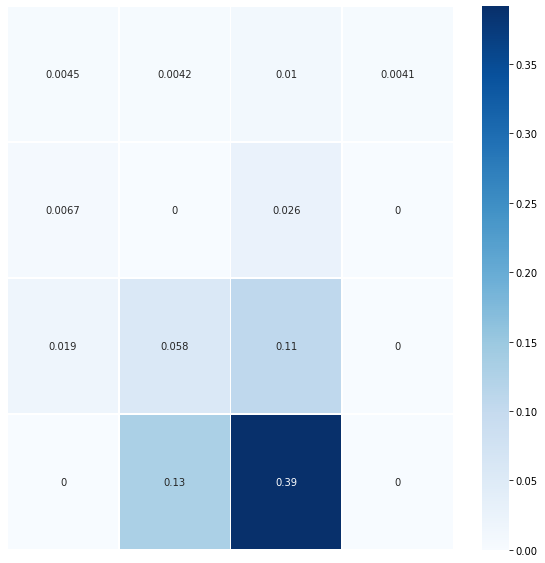

In [ ]:
visualize_V(V, (4,4))

In [ ]:
env.render()


SFFF
FHFH
FFFH
HFFG


#### Policy improvement

In [ ]:
def get_Q(V, env, gamma=0.9):
    """ Calculates Q = value value fucntion based on V.""" 
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(env.observation_space.n):
      for action in range(env.action_space.n):
          ###########################################################
          # Calculate state action value based on V and env.P info. #
          ########################################################### 
          Q[state][action] = 1
    return Q

In [ ]:
# Test your get_Q fucntion
game = "FrozenLake-v0"
env = gym.make(game, map_name="4x4", is_slippery=False)

V_test = np.array([0.0045, 0.0042, 0.0101, 0.0041, 0.0067, 0., 0.0263, 0., 0.0187, 0.0576, 0.107, 0., 0., 0.1304, 0.3915, 0.])
Q_expected = np.array([
       [0.004, 0.006, 0.004, 0.004],
       [0.004, 0.   , 0.009, 0.004],
       [0.004, 0.024, 0.004, 0.009],
       [0.009, 0.   , 0.004, 0.004],
       [0.006, 0.017, 0.   , 0.004],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.096, 0.   , 0.009],
       [0.   , 0.   , 0.   , 0.   ],
       [0.017, 0.   , 0.052, 0.006],
       [0.017, 0.117, 0.096, 0.   ],
       [0.052, 0.352, 0.   , 0.024],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.117, 0.352, 0.052],
       [0.117, 0.352, 1.   , 0.096],
       [0.   , 0.   , 0.   , 0.   ]])


np.testing.assert_array_equal(Q_expected, get_Q(V_test, env, gamma=0.9).round(3))

In [ ]:
def get_Q(V, env, gamma=0.9):
    """ Calculates Q = value value fucntion based on V.""" 
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(env.observation_space.n):
      for action in range(env.action_space.n):
        for prob, next_state, reward, done in env.P[state][action]:
            Q[state][action] += prob * (reward + gamma * V[next_state])
    return Q

In [ ]:
Q = get_Q(V, env)
Q

array([[0.00405, 0.00603, 0.00378, 0.00405],
       [0.00405, 0.     , 0.00909, 0.00378],
       [0.00378, 0.02367, 0.00369, 0.00909],
       [0.00909, 0.     , 0.00369, 0.00369],
       [0.00603, 0.01683, 0.     , 0.00405],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.0963 , 0.     , 0.00909],
       [0.     , 0.     , 0.     , 0.     ],
       [0.01683, 0.     , 0.05184, 0.00603],
       [0.01683, 0.11736, 0.0963 , 0.     ],
       [0.05184, 0.35235, 0.     , 0.02367],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.11736, 0.35235, 0.05184],
       [0.11736, 0.35235, 1.     , 0.0963 ],
       [0.     , 0.     , 0.     , 0.     ]])

In [ ]:
state = 0
Q[state][DOWN]

0.006030000000000001

In [ ]:
def policy_improvement(V, env, gamma=0.9):
    """Generate new policy based on max values for each state in Q"""
    policy = np.zeros([env.observation_space.n, env.action_space.n])
    Q = get_Q(V, env, gamma)
    for state in range(env.observation_space.n):
        # There can be multiple maximal options in Q[state].
        best_actions = np.argwhere(Q[state]==np.max(Q[state])).flatten()
        # We distribute probability of action evenly amongs maximum values.
        policy[state] = np.sum([np.eye(env.nA)[a] for a in best_actions], axis=0) / len(best_actions)
    return policy


In [ ]:
policy = policy_improvement(V, env)
policy

array([[0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [ ]:
def visualize_policy(policy, shape):
  policy_mapping = {
    0: "LEFT",
    1: "DOWN",
    2: "RIGHT",
    3: "UP"
  }
  readable_policy = []
  for state in range(policy.shape[0]):
    # In case of multiple maximas we take first letter of each maximal action.
    possible_moves = list(np.argwhere(policy[state] == np.max(policy[state])).flatten())
    code = "".join(map(lambda move: policy_mapping[move][0], possible_moves))
    readable_policy.append(code)
  return pd.DataFrame(np.array(readable_policy).reshape(shape))


In [ ]:
visualize_policy(policy, (4, 4))

,0,1,2,3
0,D,R,D,L
1,D,LDRU,D,LDRU
2,R,D,D,LDRU
3,LDRU,R,R,LDRU


#### Policy iteration

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=True)

In [ ]:
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [ ]:
np.arange(64).reshape((8,8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [ ]:
# Policy iteration algorithm
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
improvement = 1e-3
gamma = 0.9

for _ in tqdm.tqdm(range(1000), total=1000):
  ############################################
  # Use policy evaluation and improvement to #
  #       calculate the best policy          #
  ############################################
  new_policy = policy.copy()
  V = np.ones(env.observation_space.n)
  if np.all(policy == new_policy):
    break
  policy = new_policy.copy()

  0%|          | 0/1000 [00:00<?, ?it/s]


In [ ]:
# Policy iteration algorithm
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
improvement = 1e-3
gamma = 0.9

for _ in tqdm.tqdm(range(1000), total=1000):
  # Calculate V function based on current policy.
  V = policy_evaluation(policy, env, improvement=improvement, gamma=gamma)
  # Improve policy based on new value function.
  new_policy = policy_improvement(V, env)
  if np.all(policy == new_policy):
    break
  policy = new_policy.copy()

  0%|          | 0/1000 [00:00<?, ?it/s]


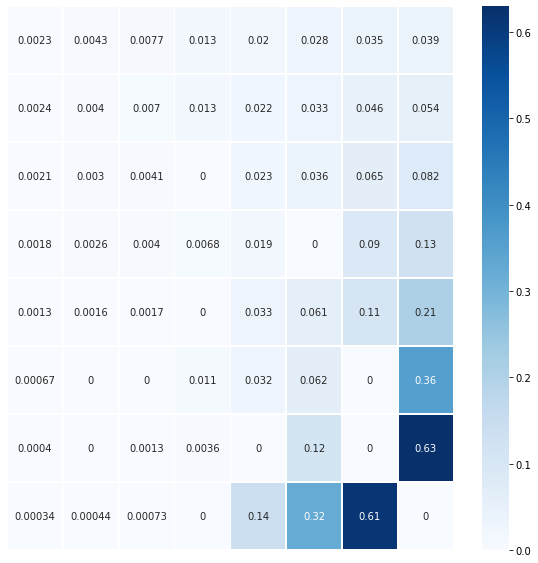

In [ ]:
visualize_V(V, (8, 8))

In [ ]:
visualize_policy(policy, shape=(8,8))

,0,1,2,3,4,5,6,7
0,D,R,R,R,R,R,R,R
1,U,R,R,U,R,R,R,D
2,U,R,L,LDRU,R,U,R,D
3,U,U,U,DU,L,LDRU,R,D
4,U,U,LU,LDRU,R,D,U,R
5,L,LDRU,LDRU,DR,U,L,LDRU,R
6,L,LDRU,DR,LU,LDRU,LR,LDRU,R
7,RU,D,L,LDRU,DR,D,D,LDRU


In [ ]:
def get_action(state, policy, action_space_size):
  ##############################################
  # Use np.random.choice to sample from policy #
  ##############################################
  return 0

In [ ]:
def get_action(state, policy, action_space_size):
  return np.random.choice(action_space_size, size=1, p=policy[state])[0]

In [ ]:
get_action(6, policy, env.action_space.n)

2

In [ ]:
# Game play

game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=False)
state = env.reset()

for iteration in range(100):
  # Sampling random action from policy.
  action = get_action(state, policy, env.action_space.n)
  # Applying action in the envrinment.
  next_state, reward, done, info = env.step(action)

  ipythondisplay.clear_output(wait=True)
  screen = env.render('ansi')
  print(screen)
  print()
  print('Action', action)
  print('Obs', next_state)
  print('Reward', reward)
  print('Done', done)
  print('Info', info)
  time.sleep(0.3)
  if done:
    print(f"We finished after {iteration} iterations")
    break
  state = next_state  
env.close()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 2
Obs 63
Reward 1.0
Done True
Info {'prob': 0.3333333333333333}
We finished after 65 iterations


**Questions and experiment suggestions:**
 - Change environment to `is_slippery=True` and explore final policy, use `env.P` to understand strange moves agent does.
 - Try policy trained in slippery env in non-slippery one and vice versa

## Model Free Value Based Methods - Intro
Methods exploring environment without knowledge of `env.P` or state size.
 - Monte Carlo policy evaluation
 - SARSA policy evaluation
 - Eps greedy policy imporovement
 - Monte Carlo control
 - Temporad Differece learning
 - Q learning 

#### Monte Carlo policy evaluation
We don't know how many states the environment has, neither the `env.P`

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=True)
# Defalut policy for unknow state is random.
policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)

In [ ]:
def sample_episode_with_policy(env, policy):
  """Samples the environment with given policy and return whole episode
     Return: List of tuples in form (state, action, reward)
  
  """
  episode = []
  state = env.reset()

  while True:
    ####################################################
    # Use get_action and sample whole episode from env #
    ####################################################
    episode.append((0, 0, 0))
    break
  return episode

In [ ]:
def sample_episode_with_policy(env, policy):
  """Samples the environment with given policy and return whole episode
     Return: List of tuples in form (state, action, reward)
  """
  episode = []
  state = env.reset()

  while True:
    # Sampling random action.
    action = get_action(state, policy, env.action_space.n)
    # Applying action to the envrinment.
    next_state, reward, done, info = env.step(action)
    episode.append((state, action, reward))
    if done:
      break
    state = next_state  
  return episode

In [ ]:
episode = sample_episode_with_policy(env, policy)

In [ ]:
states, actions, rewards = zip(*episode)
states[:10]

(0, 0, 0, 0, 1, 1, 2, 2, 2, 1)

In [ ]:
def monte_carlo_policy_evaluation(env, policy, episodes=100000, gamma=0.9):
    V_sum = defaultdict(lambda: 0)
    V = defaultdict(lambda: 0)
    N = defaultdict(lambda: 1)
    
    for _ in tqdm.tqdm(range(episodes), total=episodes):
        episode = sample_episode_with_policy(env, policy)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # For each sampled state we just take the future rewards.
        for i, state in enumerate(states):
            V_sum[state] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state] += 1.0
            V[state] = V_sum[state] / N[state]
    return V

In [ ]:
V_88_fully_observed = np.array([
    2.29653381e-03, 4.29793949e-03, 7.68631636e-03, 1.30663401e-02,
    2.04641425e-02, 2.80023242e-02, 3.53658586e-02, 3.89813210e-02,
    2.36442306e-03, 4.03609913e-03, 6.98708839e-03, 1.25036067e-02,
    2.23853616e-02, 3.26115765e-02, 4.60724853e-02, 5.43998377e-02,
    2.05340250e-03, 3.04690072e-03, 4.13369095e-03, 0.00000000e+00,
    2.28824747e-02, 3.59909643e-02, 6.50721793e-02, 8.20680850e-02,
    1.77606465e-03, 2.57038383e-03, 3.98215617e-03, 6.75075057e-03,
    1.88285925e-02, 0.00000000e+00, 8.97769561e-02, 1.27394169e-01,
    1.31970075e-03, 1.63676913e-03, 1.68567759e-03, 0.00000000e+00,
    3.33625696e-02, 6.08771461e-02, 1.07568995e-01, 2.08258357e-01,
    6.74217955e-04, 0.00000000e+00, 0.00000000e+00, 1.05864198e-02,
    3.18860875e-02, 6.24689945e-02, 0.00000000e+00, 3.59126905e-01,
    3.98921444e-04, 0.00000000e+00, 1.27635601e-03, 3.55883275e-03,
    0.00000000e+00, 1.15509244e-01, 0.00000000e+00, 6.30053460e-01,
    3.39424326e-04, 4.43979005e-04, 7.31093115e-04, 0.00000000e+00,
    1.38238204e-01, 3.22568611e-01, 6.14432521e-01, 0.00000000e+00])


mses = []
for ep in [0, 100, 1000, 10000]:
  ###########################################################
  # Run mc evaluation with different episode count,         #
  # convert sampled V to numpy format and                   #
  # calculate how mean square error between sampled V and   #
  # V_88_fully_observed changed                             #
  ########################################################### 
print()
print(mses)

In [ ]:
V_88_fully_observed = np.array([
    2.29653381e-03, 4.29793949e-03, 7.68631636e-03, 1.30663401e-02,
    2.04641425e-02, 2.80023242e-02, 3.53658586e-02, 3.89813210e-02,
    2.36442306e-03, 4.03609913e-03, 6.98708839e-03, 1.25036067e-02,
    2.23853616e-02, 3.26115765e-02, 4.60724853e-02, 5.43998377e-02,
    2.05340250e-03, 3.04690072e-03, 4.13369095e-03, 0.00000000e+00,
    2.28824747e-02, 3.59909643e-02, 6.50721793e-02, 8.20680850e-02,
    1.77606465e-03, 2.57038383e-03, 3.98215617e-03, 6.75075057e-03,
    1.88285925e-02, 0.00000000e+00, 8.97769561e-02, 1.27394169e-01,
    1.31970075e-03, 1.63676913e-03, 1.68567759e-03, 0.00000000e+00,
    3.33625696e-02, 6.08771461e-02, 1.07568995e-01, 2.08258357e-01,
    6.74217955e-04, 0.00000000e+00, 0.00000000e+00, 1.05864198e-02,
    3.18860875e-02, 6.24689945e-02, 0.00000000e+00, 3.59126905e-01,
    3.98921444e-04, 0.00000000e+00, 1.27635601e-03, 3.55883275e-03,
    0.00000000e+00, 1.15509244e-01, 0.00000000e+00, 6.30053460e-01,
    3.39424326e-04, 4.43979005e-04, 7.31093115e-04, 0.00000000e+00,
    1.38238204e-01, 3.22568611e-01, 6.14432521e-01, 0.00000000e+00])


mses = []
for ep in [0, 100, 1000, 10000]:
  V = monte_carlo_policy_evaluation(env, policy, episodes=ep, gamma=0.9)
  V_88_mc = np.zeros(64)
  for state, value in V.items():
    V_88_mc[state] = value
  mse = np.mean(np.power(V_88_fully_observed - V_88_mc, 2))
  mses.append(mse)

print()
print(mses)

0it [00:00, ?it/s]
100%|██████████| 10000/10000 [00:46<00:00, 216.90it/s]


[0.018022184973084263, 0.0016500964694391843, 0.00014848176707407362, 2.1386484902138443e-05]


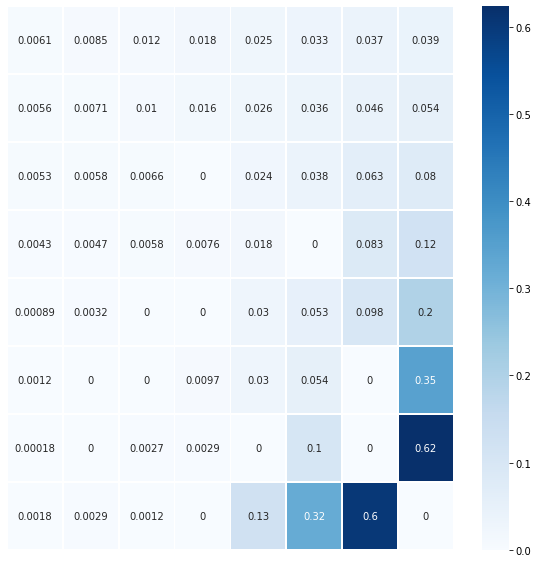

In [ ]:
visualize_V(V_88_mc, shape=(8,8))

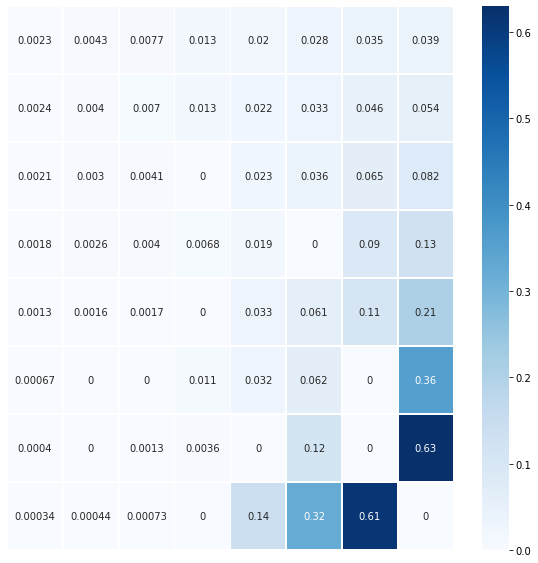

In [ ]:
visualize_V(V_88_fully_observed, shape=(8,8))

#### Monte Carlo Control  

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=False)

In [ ]:
def get_policy_Qs(Qs, action_space_size, eps=0.99):
  """Get eps greedy policy for given state based of Q value."""
  policy = np.ones(action_space_size) * eps / action_space_size
  max_action_position = np.argwhere(Qs==np.max(Qs)).flatten()
  policy[max_action_position] = (1 - eps) / len(max_action_position) + eps / action_space_size
  return policy

def get_action_Q(state, Q, action_space_size, eps=0.99):
  """Sampling action based on Q using epsilon greedy policy"""
  if state not in Q:
    return np.random.choice(np.arange(action_space_size))
  return np.random.choice(np.arange(action_space_size), p=get_policy_Qs(Q[state], action_space_size, eps))
  

In [ ]:
get_policy_Qs(np.array([1,2,3,2,3]), action_space_size=5, eps=0.5)

array([0.1 , 0.1 , 0.35, 0.1 , 0.35])

In [ ]:
def sample_episode_with_Q(env, Q, eps=0.99):
  episode = []
  state = env.reset()

  while True:
    action = get_action_Q(state, Q, env.action_space.n, eps)
    next_state, reward, done, info = env.step(action)
    episode.append((state, action, reward))
    if done:
      break
    state = next_state  
  return episode

In [ ]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))
episode = sample_episode_with_Q(env, Q)
episode[:4]

[(0, 2, 0.0), (1, 2, 0.0), (2, 1, 0.0), (10, 1, 0.0)]

In [ ]:
def monte_carlo_control(env, episodes, alpha=0.01, gamma=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    """Monte carlo sampling of environment and improving Q with eps-greedy policy
       Params:
          alpha: Approxiation of 1/N term in monte carlo policy evaluaton.
          gamma: Future reward discount.
          eps: How much we we explore rather than exploit env.
          eps_decay: Decrease eps each iteration.
      Return: Estimated Q function
    """

    action_space_size = env.action_space.n
    Q = defaultdict(lambda: np.zeros(action_space_size))
    eps = eps_start
    # In each iteration we sample episode and  update Q and policy
    for _ in tqdm.tqdm(range(episodes), total=episodes):
        # Decrease eps
        eps = max(eps*eps_decay, eps_min)
        episode = sample_episode_with_Q(env, Q, eps)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Using same discount strategy as with mc policy evaluation.
        for i, state in enumerate(states):
            cumulative_reward = sum(rewards[i:]*discounts[:-(1+i)])
            action = actions[i]
            # Q average value with just approximation of N.
            Q[state][action] = Q[state][action] + alpha * (cumulative_reward - Q[state][action])
    return Q

In [ ]:
Q = monte_carlo_control(env, episodes=25000, eps_start=0.5, alpha=0.01)

100%|██████████| 25000/25000 [01:23<00:00, 297.66it/s]


In [ ]:
# For visualization we cheat with prior about size of states.
policy_q = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
for state, Qs in Q.items():
  policy_q[state] = get_policy_Qs(Qs, env.action_space.n, eps=0)
visualize_policy(policy_q, shape=(8, 8))

,0,1,2,3,4,5,6,7
0,R,R,D,R,D,R,D,U
1,U,D,U,U,R,R,L,D
2,R,L,R,LDRU,R,D,R,D
3,D,U,R,R,D,LDRU,R,D
4,U,U,U,LDRU,U,D,U,R
5,LDRU,LDRU,LDRU,LDRU,L,D,LDRU,R
6,LDRU,LDRU,LDRU,LDRU,LDRU,R,LDRU,D
7,LDRU,LDRU,LDRU,LDRU,LDRU,U,R,LDRU


In [ ]:
state = env.reset()
for iteration in range(100):
  # Sampling random action.
  action = get_action_Q(state, Q, env.action_space.n, eps=0.1)
  # Applying action in the envrinment.
  next_state, reward, done, info = env.step(action)

  ipythondisplay.clear_output(wait=True)
  screen = env.render('ansi')
  print(screen)
  print()
  print('Action', action)
  print('Obs', next_state)
  print('Reward', reward)
  print('Done', done)
  print('Info', info)
  time.sleep(0.05)
  if done:
    print(f"We finished after {iteration} iterations")
    break
  state = next_state  
env.close()

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Action 3
Obs 35
Reward 0.0
Done True
Info {'prob': 0.3333333333333333}
We finished after 30 iterations


**Questions and experiment suggestions:**
 - Change environment to `is_slippery=True` and find sample count which produce reasonable policy
 - Write function calculating cumulative reward of N agent runs with given policy and different *eps*

In [ ]:
cumulative_reward = 0
eps = 0.5
for _ in tqdm.tqdm(range(1000), total=1000):
  state = env.reset()
  for iteration in range(100):
    # Sampling random action.
    action = get_action_Q(state, Q, env.action_space.n, eps=eps)
    # Applying action in the envrinment.
    next_state, reward, done, info = env.step(action)
    if done:
      break
    state = next_state
  cumulative_reward += reward  
  env.close()

print()
print('Cumulative reward is', cumulative_reward)

100%|██████████| 1000/1000 [00:02<00:00, 338.07it/s]


Cumulative reward is 15.0


#### Temporal Difference

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=False)

In [ ]:
def td_sarsa(env, episodes, alpha=0.01, gamma=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    """Temporal difference SARSA apprach with eps greedy policy to estimate Q.
       Params:
          alpha: Approxiation of 1/N term in monte carlo policy evaluaton.
          gamma: Future reward discount.
          eps: How much we we explore rather than exploit env.
          eps_decay: Decrease eps each iteration.
      Return: Estimated Q function
    """
    action_space_size = env.action_space.n
    eps = eps_start
    Q = defaultdict(lambda: np.zeros(action_space_size))

    for _ in tqdm.tqdm(range(episodes), total=episodes):
        eps = max(eps*eps_decay, eps_min)
        # We now sample evry step, not after finishing the episode.
        state = env.reset()
        action = get_action_Q(state, Q, env.action_space.n, eps)
        # Here starts one episode.
        while True:
            next_state, reward, done, info = env.step(action)
            if not done:
                next_action = action
                #######################################################################
                # Calculate next_action, estimate td_target and td_error and update Q #
                #######################################################################
                Q[state][action] = 1 
            # We can not sample next step in case we finished.
            else:
                #####################################################
                # Calculate simplified td_error without next_action #
                #####################################################
                Q[state][action]  = 1
                break
            state = next_state
            action = next_action  
    return Q

In [ ]:
def td_sarsa(env, episodes, alpha=0.01, gamma=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    """Temporal difference SARSA apprach with eps greedy policy to estimate Q.
       Params:
          alpha: Approxiation of 1/N term in monte carlo policy evaluaton.
          gamma: Future reward discount.
          eps: How much we we explore rather than exploit env.
          eps_decay: Decrease eps each iteration.
      Return: Estimated Q function
    """
    action_space_size = env.action_space.n
    eps = eps_start
    Q = defaultdict(lambda: np.zeros(action_space_size))

    for _ in tqdm.tqdm(range(episodes), total=episodes):
        eps = max(eps*eps_decay, eps_min)
        # We now sample evry step, not after finishing the episode.
        state = env.reset()
        action = get_action_Q(state, Q, env.action_space.n, eps)
        # Here starts one episode.
        while True:
            next_state, reward, done, info = env.step(action)
            if not done:
                next_action = get_action_Q(next_state, Q, env.action_space.n, eps)
                # We just estimate cummulative reward based on sarsa sample and current Q.
                td_target = reward + gamma * Q[next_state][next_action]
                td_error = td_target - Q[state][action]
                Q[state][action] += alpha * td_error
            # We can not sample next step in case we finished.
            else:
                td_target = reward
                td_error = td_target - Q[state][action]
                Q[state][action] += alpha * td_error
                break
            state = next_state
            action = next_action  
    return Q

In [ ]:
game = "FrozenLake-v0"
env = gym.make(game, map_name="8x8", is_slippery=True)

In [ ]:
Q = td_sarsa(env, episodes=25000, alpha=0.01, eps_start=1)

100%|██████████| 25000/25000 [01:16<00:00, 328.44it/s]


In [ ]:
policy_q = np.ones([64, env.action_space.n]) / env.action_space.n
for state, Qs in Q.items():
  policy_q[state] = get_policy_Qs(Qs, env.action_space.n, eps=0)
visualize_policy(policy_q, shape=(8, 8))

,0,1,2,3,4,5,6,7
0,U,R,R,R,R,R,R,R
1,U,R,U,U,R,R,D,D
2,U,U,L,LDRU,R,R,R,D
3,U,U,U,U,R,LDRU,R,D
4,U,U,L,LDRU,U,R,D,R
5,U,LDRU,LDRU,D,R,L,LDRU,L
6,L,LDRU,R,U,LDRU,R,LDRU,R
7,L,D,U,LDRU,R,L,U,LDRU


In [ ]:
cumulative_reward = 0
for _ in tqdm.tqdm(range(1000), total=1000):
  state = env.reset()
  for iteration in range(100):
    # Sampling random action.
    action = get_action_Q(state, Q, env.action_space.n, eps=0)
    # Applying action in the envrinment.
    next_state, reward, done, info = env.step(action)
    if done:
      break
    state = next_state
  cumulative_reward += reward  
  env.close()

print('Cumulative reward is', cumulative_reward)

100%|██████████| 1000/1000 [00:04<00:00, 234.73it/s]

Cumulative reward is 137.0


**Questions and experiment suggestions:**
 - Compare quality of results between mc_control and td_sarsa

#### Q learining control (off policy)
Learinig from optimal policy while following exploratory policy

In [ ]:
def Q_learning(env, episodes, alpha=0.01, gamma=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    """Q learning apprach with eps greedy policy to estimate Q.
       Params:
          alpha: Approxiation of 1/N term in monte carlo policy evaluaton.
          gamma: Future reward discount.
          eps: How much we we explore rather than exploit env.
          eps_decay: Decrease eps each iteration.
      Return: Estimated Q function
    """
    action_space_size = env.action_space.n
    eps = eps_start
    Q = defaultdict(lambda: np.zeros(action_space_size))

    for _ in tqdm.tqdm(range(episodes), total=episodes):
        eps = max(eps*eps_decay, eps_min)
        # We now sample evry step, not after finishing the episode.
        state = env.reset()
        # Here starts one episode.
        while True:
            action = get_action_Q(state, Q, env.action_space.n, eps)
            next_state, reward, done, info = env.step(action)
            if not done:
                # We just estimate cummulative reward based on sars sample and current Q.
                td_target = reward + gamma * max(Q[next_state])
                td_error = td_target - Q[state][action]
                Q[state][action] += alpha * td_error
            # We can not sample next step in case we finished.
            else:
                td_target = reward
                td_error = td_target - Q[state][action]
                Q[state][action] += alpha * td_error
                break
            state = next_state
    return Q

In [ ]:
Q = Q_learning(env, episodes=25000, alpha=0.01, eps_start=1)

100%|██████████| 25000/25000 [01:21<00:00, 307.28it/s]


In [ ]:
policy_q = np.ones([64, env.action_space.n]) / env.action_space.n
for state, Qs in Q.items():
  policy_q[state] = get_policy_Qs(Qs, env.action_space.n, eps=0)
visualize_policy(policy_q, shape=(8, 8))

,0,1,2,3,4,5,6,7
0,U,R,R,R,R,R,R,R
1,U,U,U,U,R,R,R,D
2,U,U,L,LDRU,R,R,R,D
3,U,U,U,U,L,LDRU,R,R
4,U,U,L,LDRU,D,D,U,R
5,L,LDRU,LDRU,U,U,L,LDRU,R
6,U,LDRU,R,U,LDRU,L,LDRU,D
7,L,U,U,LDRU,D,U,R,LDRU


In [ ]:
cumulative_reward = 0
for _ in tqdm.tqdm(range(1000), total=1000):
  state = env.reset()
  for iteration in range(100):
    # Sampling random action.
    action = get_action_Q(state, Q, env.action_space.n, eps=0)
    # Applying action in the envrinment.
    next_state, reward, done, info = env.step(action)
    if done:
      break
    state = next_state
  cumulative_reward += reward  
  env.close()

print('Cumulative reward is', cumulative_reward)

100%|██████████| 1000/1000 [00:04<00:00, 218.83it/s]

Cumulative reward is 314.0


## Model Free Value Based Methods - Deep Q-Learning
 - Lunar environment
 - Replay buffer
 - QNetwork architecture
 - QAgent 
 - Deep Qlearning algorithm


#### Environment exploration

In [7]:
game = "LunarLander-v2"
env = gym.make(game)

In [8]:
env.observation_space.shape[0]

8

In [9]:
env.action_space.n

4

In [10]:
lunar_actions = {
    'none': 0,
    'left': 1,
    'up': 2,
    'right': 3
}

In [11]:
state = env.reset()
state

array([ 0.00479584,  1.4068085 ,  0.48574752, -0.18275005, -0.00555038,
       -0.1100292 ,  0.        ,  0.        ], dtype=float32)

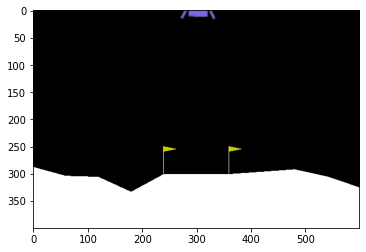

In [12]:
next_state, reward, done, info = env.step(lunar_actions['left'])
plt.imshow(env.render('rgb_array'))

In [13]:
env.close()

In [14]:
logging_path = '/video/lunar/test/'
env = wrap_env(gym.make("LunarLander-v2"), logging_path)
state = env.reset()
while True:
    # 'human' type of rendenring is suitable when we do the recording
    env.render('human')
    action = env.action_space.sample()      
    state, reward, done, info = env.step(action) 
    if done: 
      break;   
env.close()
show_video(path_prefix=logging_path)

#### Replay buffer

In [6]:
class QReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, buffer_size=int(1e5), batch_size=64, seed=42, device='cpu'):
        """Initialize a ReplayBuffer object.
        Params:
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (str): device where tensors are proecssed
        """

        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.device = device
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=None):
        """Randomly sample a batch of experiences from memory."""
        batch_size = batch_size if batch_size is not None else self.batch_size
        batch = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(np.vstack([b.state for b in batch if b is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([b.action for b in batch if b is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([b.reward for b in batch if b is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([b.next_state for b in batch if b is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([b.done for b in batch if b is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def is_ready_to_sample(self):
        return len(self) > self.batch_size

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    def set_device(self, device):
        self.device = device

In [7]:
# Try to fill in data into buffer and sample batches from it.
game = "LunarLander-v2"
env = gym.make(game)
replay_buffer = QReplayBuffer(batch_size=30)

for _ in tqdm.tqdm(range(100)):
  state = env.reset()
  while True:
      action = env.action_space.sample()      
      next_state, reward, done, info = env.step(action)
      replay_buffer.add(state, action, reward, next_state, done)
      state = next_state
      if done: 
        break;   
env.close()

100%|██████████| 100/100 [00:01<00:00, 65.21it/s]


In [8]:
len(replay_buffer)

9426

In [9]:
states, actions, rewards, next_states, dones = replay_buffer.sample(2)
states

tensor([[ 0.0810,  1.4071,  0.4678, -0.1374,  0.0126,  0.1086,  0.0000,  0.0000],
        [-0.0096,  1.3724, -0.3222, -0.5886,  0.0071,  0.0155,  0.0000,  0.0000]])

#### Q network

In [10]:
class DuelingQNetwork(torch.nn.Module):
    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.bn0 = torch.nn.BatchNorm1d(state_size)
        self.fc_layer1 = torch.nn.Linear(state_size, 64)
        torch.nn.init.xavier_normal_(self.fc_layer1.weight)
        self.fc_bn1 = torch.nn.BatchNorm1d(64)

        self.fc_layer2 = torch.nn.Linear(64, 64)
        torch.nn.init.xavier_normal_(self.fc_layer2.weight)
        self.fc_bn2 = torch.nn.BatchNorm1d(64)

        self.value_layer1 = torch.nn.Linear(64, 32)
        torch.nn.init.xavier_normal_(self.value_layer1.weight)
        self.v_bn1 = torch.nn.BatchNorm1d(32)
        self.value_layer2 = torch.nn.Linear(32, 1)

        self.action_layer1 = torch.nn.Linear(64, 32)
        torch.nn.init.xavier_normal_(self.action_layer1.weight)
        self.a_bn1 = torch.nn.BatchNorm1d(32)
        self.action_layer2 = torch.nn.Linear(32, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        #x = self.bn0(x)

        # Shared part of network.
        x = self.fc_layer1(x)
        torch.nn.functional.leaky_relu_(x)
        #x = self.fc_bn1(x)

        x = self.fc_layer2(x)
        torch.nn.functional.leaky_relu_(x)
        #x = self.fc_bn2(x)

        # Value part of network.
        v = self.value_layer1(x)
        torch.nn.functional.leaky_relu_(v)
        #v = self.v_bn1(v)        
        v = self.value_layer2(v)

        # Advantage part of network
        a = self.action_layer1(x)
        torch.nn.functional.leaky_relu_(a)
        #a = self.a_bn1(a)        
        a = self.action_layer2(a)

        return v + (a - torch.mean(a, dim=1).unsqueeze(1))

In [11]:
qnetwork = DuelingQNetwork(state_size=8, action_size=4, seed=42)

In [12]:
qnetwork.eval()
result = qnetwork(states)
states, result

(tensor([[ 0.0810,  1.4071,  0.4678, -0.1374,  0.0126,  0.1086,  0.0000,  0.0000],
         [-0.0096,  1.3724, -0.3222, -0.5886,  0.0071,  0.0155,  0.0000,  0.0000]]),
 tensor([[0.3447, 0.3793, 0.2749, 0.3065],
         [0.3758, 0.3967, 0.2666, 0.2679]], grad_fn=<AddBackward0>))

#### Agent

In [ ]:
class QAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, tau=1e-3, eps=0., gamma=0.99, lr=5e-4, seed=0, device='cpu'):
        """Initialize an Agent object.
        Params:
            state_size (int): Dimension of input state.
            action_size (int): Dimension of actions.
            seed (int): Random seed for reproducibility.
            lr (float): Learning rate.
            gamma (float): Reward discount.
            tau (float): For soft update of target network parameters (tau is weight for local network).
            eps (float): For epsilon-greedy action selection, higher eps means more exploration.
        """
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.eps = eps
        self.state_size = state_size
        self.action_size = action_size

        # Stabilization of training using target network.
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=lr)

    def __repr__(self):
        return f'QAgent(state_size={self.state_size}, action_size={self.action_size}, device="{self.device}")'

    def act(self, state, eps=None):
        """Return action for given state.
        Params:
            state (numpy.array): Current state.
            eps (float): Eps overlad.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        if eps is None:
            eps = self.eps

        is_training = self.qnetwork_local.training
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train(is_training)

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def train(self, replay_buffer, gamma=None, tau=None, batch_size=None):
        """Update value parameters using sampled batches from replay buffer.
        Params:
            replay_buffer: Buffer with records from history.
            gamma (float): Discount factor.
            tau (float): For soft update of target network parameters
        """

        if gamma is None:
            gamma = self.gamma
        if not replay_buffer.is_ready_to_sample():
            return None
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = batch
        
        self.qnetwork_local.train()
        ###########################################################
        # Use rewards and qnetwork_target to buld target Q value. #
        # Think about corner situation when we are done.          #
        ###########################################################
        target = self.qnetwork_target(states)[:, 1].unsqueeze(1)
        ########################################################
        # Use local network to define a prediction for Q(s,a). #
        ########################################################
        prediction = self.qnetwork_local(states)[:, 1].unsqueeze(1)

        loss = torch.nn.functional.mse_loss(target, prediction)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)

    def soft_update(self, local_model, target_model, tau=None):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params:
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): For soft update of target network parameters
        """
        if tau is None:
            tau = self.tau

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def set_device(self, device):
      self.device = device
      self.qnetwork_local = self.qnetwork_local.to(device)
      self.qnetwork_target = self.qnetwork_target.to(device)
    
    def save(self, path):
        folder, file = path.rsplit('/', 1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(self.qnetwork_local.state_dict(), path)

    def load(self, path):
        self.qnetwork_local.load_state_dict(torch.load(path))
        self.qnetwork_target.load_state_dict(torch.load(path))

In [15]:
class QAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, tau=1e-3, eps=0., gamma=0.99, lr=5e-4, seed=0, device='cpu'):
        """Initialize an Agent object.
        Params:
            state_size (int): Dimension of input state.
            action_size (int): Dimension of actions.
            seed (int): Random seed for reproducibility.
            lr (float): Learning rate.
            gamma (float): Reward discount.
            tau (float): For soft update of target network parameters (tau is weight for local network).
            eps (float): For epsilon-greedy action selection, higher eps means more exploration.
        """
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.eps = eps
        self.state_size = state_size
        self.action_size = action_size

        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=lr)

    def __repr__(self):
        return f'QAgent(state_size={self.state_size}, action_size={self.action_size}, device="{self.device}")'

    def act(self, state, eps=None):
        """Return action for given state.
        Params:
            state (numpy.array): Current state.
            eps (float): Eps overlad.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        if eps is None:
            eps = self.eps

        is_training = self.qnetwork_local.training
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train(is_training)

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def train(self, replay_buffer, gamma=None, tau=None, batch_size=None):
        """Update value parameters using sampled batches from replay buffer.
        Params:
            replay_buffer: Buffer with records from history.
            gamma (float): Discount factor.
            tau (float): For soft update of target network parameters
        """

        if gamma is None:
            gamma = self.gamma
        if not replay_buffer.is_ready_to_sample():
            return None
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = batch
        
        self.qnetwork_local.train()
        target = rewards + gamma * self.qnetwork_target(next_states).max(dim=1)[0].unsqueeze(1) * (1 - dones)
        prediction = self.qnetwork_local(states).gather(dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(target, prediction)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)

    def soft_update(self, local_model, target_model, tau=None):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params:
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): For soft update of target network parameters
        """
        if tau is None:
            tau = self.tau

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def set_device(self, device):
      self.device = device
      self.qnetwork_local = self.qnetwork_local.to(device)
      self.qnetwork_target = self.qnetwork_target.to(device)
    
    def save(self, path):
        folder, file = path.rsplit('/', 1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(self.qnetwork_local.state_dict(), path)

    def load(self, path):
        self.qnetwork_local.load_state_dict(torch.load(path))
        self.qnetwork_target.load_state_dict(torch.load(path))

In [42]:
agent = QAgent(state_size=8, action_size=4, seed=0)
agent.act(state=np.array([1, 2, 3, 4, 5, 6, 7, 8]))


3

#### Q learning algorithm

In [ ]:
#######################
# Setup of parameters #
#######################

episodes = 2000                           # Number of episodes played.
steps_per_episodes = 1000                 # Maximal amount of steps in one episode.
batch_size = 64                           # Size of batches sampled during training from replay buffer.
train_rate = 4                            # Rate of episodes including training (each train_rate th).
eps = 1.0                                 # Eps params cotroling exploration / exploitation.
eps_decay = 0.995
eps_min = 0.01
gamma = 0.99                              # Reward discounting.
stop_reward = 240                         # Average reward from 100 consecutive runs which would stop algorithm.
rewards_window = deque(maxlen=100)        # Buffer for 100 consecutive run rewards.        
rewards = []                              # Log of all episode rewards.
model_name = 'luna'                       # Identifier of model saved params.
game = "LunarLander-v2"
seed=42
env = gym.make(game)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = QAgent(state_size=8, action_size=4, seed=0, device=device)
replay_buffer = QReplayBuffer(buffer_size=int(1e5), 
                             batch_size=batch_size, 
                             seed=seed, device=device)


#######################
# Q lerning algorithm #
#######################

for episode_id in range(episodes):
    episode_reward = 0
    # At the start of episode, we restart the environment.
    state = env.reset()
    # Here starts episode.
    for t_step in range(steps_per_episodes):
        # Agent selects action.
        action = agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        # Save experience into replay buffer.
        replay_buffer.add(state, action, reward, next_state, done)
        # Train with train_rate.
        if t_step % train_rate == 0:
            agent.train(replay_buffer, gamma=gamma, batch_size=batch_size)          
        episode_reward += reward
        if done:
            break
        state = next_state
    # Afet each episode we exploit current policy more.
    eps = max(eps*eps_decay, eps_min)

    # Reporting.
    rewards_window.append(episode_reward)
    rewards.append(episode_reward)
    print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}', end="")
    if episode_id % 100 == 0:
        print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
    if np.mean(rewards_window)>=stop_reward:
        print(f'\nSolved! Took {episode_id-100} episodes\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
        break
env.close()

In [19]:
env.close()

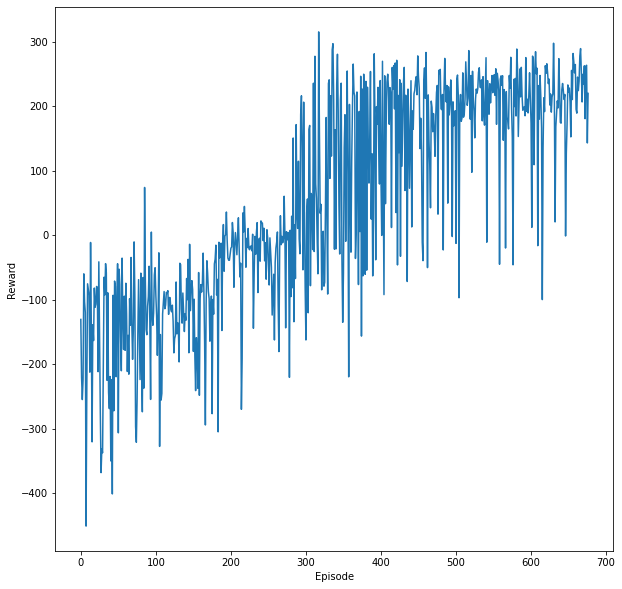

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [ ]:
!ls '/content/drive/My Drive/ml_college_data/rl_workshop/models/'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = QAgent(state_size=8, action_size=4, seed=0, device=device)

In [ ]:
model_path = os.path.join(rl_workshop_path, 'models/luna-600-204.6-173.6.pth')
video_path = '/video/lunar/'
game = "LunarLander-v2"

agent.load(path=model_path)
env = wrap_env(gym.make(game), video_path)
state = env.reset()
while True:
    env.render('human')
    action = agent.act(state, eps=0)      
    state, reward, done, info = env.step(action) 
    if done: 
      break;   
env.close()
show_video(video_path)

 **Questions and experiment suggestions:**
 - Try benefit of weighted replay buffer (weighting by current error)
 - Simplified vs batch normed vs dueling network 
 - Different eps values during training and evaluation - what are the differences?
 - Try different environments

## Policy Based Methods - Reinforce
 - simple policy network
 - reinfroce agent
 - reinforce algorith 

#### Policy network

In [56]:
class ReinforcePolicyNetwork(torch.nn.Module):
    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(ReinforcePolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc_layer1 = torch.nn.Linear(state_size, 64)
        torch.nn.init.xavier_normal_(self.fc_layer1.weight)

        self.fc_layer2 = torch.nn.Linear(64, 32)
        torch.nn.init.xavier_normal_(self.fc_layer2.weight)

        self.action_layer = torch.nn.Linear(32, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        x = self.fc_layer1(x)
        torch.nn.functional.leaky_relu_(x)

        x = self.fc_layer2(x)
        torch.nn.functional.leaky_relu_(x)
     
        logits = self.action_layer(x)
        probs =  torch.nn.functional.softmax(logits, dim=1)
        # We return both raw values and probabilities.
        return logits, probs

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = ReinforcePolicyNetwork(state_size=8, action_size=4, seed=42)
policy = policy.to(device)
policy

ReinforcePolicyNetwork(
  (fc_layer1): Linear(in_features=8, out_features=64, bias=True)
  (fc_layer2): Linear(in_features=64, out_features=32, bias=True)
  (action_layer): Linear(in_features=32, out_features=4, bias=True)
)

In [58]:
input = torch.tensor([[1, 2, 3, 4, 5, 61, 71, 81]], device=device, dtype=torch.float32)
logits, probs = policy(input)
probs

tensor([[1.4870e-04, 1.3692e-03, 3.5990e-01, 6.3859e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [59]:
####################################################################
# Use Categorial to sample action id from probability distribution #
####################################################################

dist = Categorical(probs)
actions = dist.sample()
#actions = torch.argmax(probs, dim=1)
actions ,actions.cpu().item()

(tensor([3], device='cuda:0'), 3)

#### Construct Reinforce Loss Function

In [60]:
def get_online_reinforce_loss(action_probs, rewards, gamma=1):
    ######################################################
    # Build discounted reward for each action of episode #
    #                 and calculate loss.                #
    ######################################################
    #return torch.cat([p.unsqueeze(0) for p in action_probs]).sum()

    loss = []
    discounts = [gamma**i for i in range(len(rewards)+1)]
    R = sum([a*b for a,b in zip(discounts, rewards)])
    discounts = np.array(discounts)
    rewards = np.array(rewards)
    
    for i, prob in enumerate(action_probs):
        loss.append((-torch.log(prob) * sum(rewards[i:]*discounts[:-(1+i)])).unsqueeze(0))
        #loss.append(-torch.log(prob).unsqueeze(0) * R)
    return torch.cat(loss).sum()

In [61]:
action_probs = torch.tensor([0.3, 0.1, 0.5], requires_grad=True)
rewards = [1,-1 , 1]

In [62]:
loss = get_online_reinforce_loss(action_probs, rewards)
print(loss)
assert loss.requires_grad == True
assert loss.cpu().item() in [1.8971199989318848, 4.199705123901367]

tensor(1.8971, grad_fn=<SumBackward0>)


#### Reinforce Agent

In [63]:
class ReinforceAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, gamma=1, lr=1e-3, seed=42, device='cpu'):
        """Initialize an Agent object.
        Params:
            state_size (int): Dimension of input state.
            action_size (int): Dimension of actions.
            seed (int): Random seed for reproducibility.
            gamma (float): Reward discount.
        """
        self.device = device
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size

        self.policy = ReinforcePolicyNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def __repr__(self):
        return f'ReinforceAgent(state_size={self.state_size}, action_size={self.action_size}, device="{self.device}")'

    def act(self, state, training_process=True, deterministic=False):
        """Return action and it's probability (with requires_grad) for given state and current policy.
        Params:
            state (numpy.array): Current state.
            training_process (bool): Marks whether we keep info for gradient descent or not.
            deterministic (bool): If False, we sample action from distribution, otherwise we take maximum.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        is_training = self.policy.training
        if training_process:
            self.policy.train()
            logits, probs = self.policy(state)
        else:
            self.policy.eval()
            with torch.no_grad():
                logits, probs = self.policy(state)    
        self.policy.train(is_training)

        ##########################################################################
        # Sample action from distribution if deterministic=False, else take max  #
        #                   and return action, probability scalars               #
        ##########################################################################
        #return 0, probs[0,0]
        dist = Categorical(probs)
        if deterministic:
          action = torch.argmax(probs, dim=1)
        else:
          action = dist.sample()
        action = action.cpu().item()
        return action, probs[0, action]


    def train(self, action_probs, rewards, gamma=None):
        """Update policy parameters using action probs and rewards from given episode.
        Params:
            rewards (list): List of rewards from the whole episode.
            action_probs (torch.tensor): Probabilities of sampled actions
            gamma (float): discount factor

        """
        if gamma is None:
            gamma = self.gamma
        loss = get_online_reinforce_loss(action_probs=action_probs, rewards=rewards, gamma=gamma)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def set_device(self, device):
      self.device = device
      self.policy = self.policy.to(device)
    
    def save(self, path):
        folder, file = path.rsplit('/', 1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(self.policy.state_dict(), path)

    def load(self, path):
        self.policy.load_state_dict(torch.load(path))


In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

reinforce_agent = ReinforceAgent(8, 4, device=device)
reinforce_agent

ReinforceAgent(state_size=8, action_size=4, device="cuda:0")

In [65]:
reinforce_agent.act(state=np.array([1, 2, 3, 4, 5, 61, 71, 81]))

(3, tensor(0.6386, device='cuda:0', grad_fn=<SelectBackward>))

#### Reinforce learning

In [ ]:
#######################
# Setup of parameters #
#######################

episodes = 20000
steps_per_episodes = 1000
stop_reward = 200
rewards_window = deque(maxlen=100)
rewards = []
gamma = 1
lr = 0.001
model_name='luna'
game = "LunarLander-v2"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make(game)
agent = ReinforceAgent(state_size=8, action_size=4, seed=0, gamma=gamma, lr=lr, device=device)

#######################
# Reinforce algorithm #
#######################

for episode_id in range(episodes):
    # List of rewards collected during one episode.
    episode_rewards = []
    # Action probs collected during one episode.
    episode_action_probs = []
    state = env.reset()
    for _ in range(steps_per_episodes):
        # Keep information about gradient flow.
        action, action_prob = agent.act(state, training_process=True, deterministic=False)
        next_state, reward, done, info = env.step(action)
        # Simplified buffer fill in.
        episode_rewards.append(reward)
        episode_action_probs.append(action_prob)
        if done:
            break
        state = next_state
    # Agent is trained after each episode.
    agent.train(action_probs=episode_action_probs, rewards=episode_rewards)

    # Reporting.
    episode_reward = sum(episode_rewards)
    rewards_window.append(episode_reward)
    rewards.append(episode_reward)
    print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}', end="")
    if episode_id % 100 == 0:
        print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
    if np.mean(rewards_window)>=stop_reward:
        print(f'\nSolved! Took {episode_id-100} episodes\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
        break

env.close()

In [67]:
env.close()

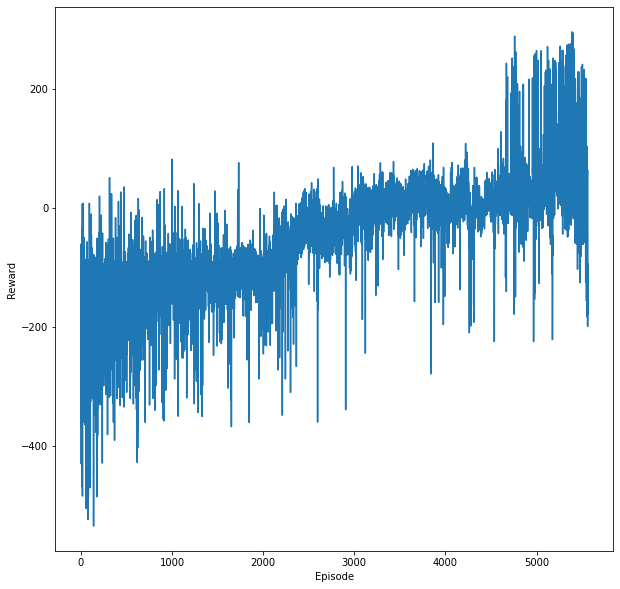

In [68]:
fig = plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [ ]:
!ls '/content/drive/My Drive/ml_college_data/rl_workshop/models/'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = ReinforceAgent(8, 4, device=device)
agent

ReinforceAgent(state_size=8, action_size=4, device="cuda:0")

In [ ]:
model_path = os.path.join(rl_workshop_path, 'models/luna-8000-86.7-76.4.pth')
video_path = '/video/luna_reinforce/'
game = "LunarLander-v2"

agent.load(path=model_path)
env = wrap_env(gym.make(game), video_path)
state = env.reset()
while True:
    env.render('human')
    action, action_prob = agent.act(state, training_process=False, deterministic=True)      
    state, reward, done, info = env.step(action) 
    if done: 
      break;   
env.close()
show_video(video_path)

 **Questions and experiment suggestions:**
 - Use reward just from future for each action
 - Train other environments: `CartPole-v0`

## Policy based methods - PPO

#### Observe Pong Env

In [8]:
game = "Pong-v0"
env = gym.make(game)

In [9]:
env.observation_space

Box(210, 160, 3)

In [10]:
env.action_space

Discrete(6)

In [11]:
env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [12]:
state = env.reset()
state.shape

(210, 160, 3)

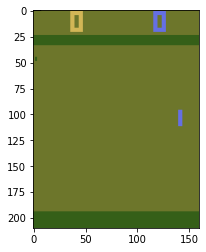

In [13]:
plt.imshow(state)

In [14]:
env.close()

#### State space preprocessing

In [15]:
def state_preprocess(state):
    """ Preprocess 210x160x3 uint8 frame into 6000 (75x80) 1D float vector. """
    #############################################################################
    #  Remove from the state as many pixels as possible and keep important ifo  #
    #   - dowscale                                                              #
    #   - greyscale                                                             #
    #   - cutoffs                                                               #
    #############################################################################

    """
      if state is None:
          return torch.zeros(210*160*3)
      return state.astype(np.float32).ravel()
    """

    if state is None:
        return torch.zeros(6000)

    state = state[35:185] # Crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle).
    state = state[::2,::2,0] # Downsample by factor of 2.
    state[state == 144] = 0 # Erase background (background type 1)
    state[state == 109] = 0 # erase background (background type 2)
    state[state != 0] = 1 # Everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    return state.astype(np.float32).ravel()

In [16]:
def get_final_state(state, prev_state):
    #######################################################
    # Experiment with combination of 2 successing images  #
    #######################################################
    #return state_preprocess(state) - state_preprocess(prev_state)
    
    return np.concatenate([state_preprocess(state), state_preprocess(prev_state)])

In [17]:
state_preprocess(None)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [18]:
get_final_state(state, None).shape

(12000,)

#### Replay Buffer

In [19]:
def get_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    dr = 0
    for r in rewards[::-1]:
        # Specific for pong - we can recognize episodes.
        if r != 0: 
          dr = 0
        dr = r + gamma * dr
        discounted_rewards.insert(0, dr)

    discounted_rewards = np.array(discounted_rewards)
    std = discounted_rewards.std()
    std = 1 if std==0 else std
    return (discounted_rewards - discounted_rewards.mean()) / std

In [20]:
get_discounted_rewards(np.array([0,0,0,0,1,0,0,0,0,-1]), gamma=0.9)

array([ 0.79238111,  0.88042345,  0.97824828,  1.08694254,  1.20771393,
       -0.79238111, -0.88042345, -0.97824828, -1.08694254, -1.20771393])

In [21]:
class PPOReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, batch_size=64, gamma=0.99, seed=42, device='cpu'):
        """Initialize a ReplayBuffer object.
        Params:
            batch_size (int): size of each training batch
            seed (int): random seed
            device (str): device where tensors are proecssed
        """
        self.batch_size = batch_size
        self.gamma = gamma
        self.is_reward_recalculated = False
        self.device = device
        self.seed = random.seed(seed)

        # Those are values we want to collect
        self.states = []
        self.actions = []
        self.action_probs = []
        self.rewards = []
        self.discounted_rewards = []

    def add(self, state, action, action_prob, reward):
        """Add a new experience to memory."""
        self.is_reward_recalculated = False
        self.states.append(state)
        self.actions.append(action)
        self.action_probs.append(action_prob)
        self.rewards.append(reward)

    def sample(self, batch_size=None):
        """Randomly sample a batch of experiences from memory."""
        idxs = random.sample(range(len(self.actions)), batch_size)

        # We need to recalculate because of normalization.
        if  not self.is_reward_recalculated:
          self.update_discounted_rewards()

        states_batch = torch.from_numpy(np.vstack([self.states[idx] for idx in idxs])).float().to(self.device)
        actions_batch = torch.from_numpy(np.vstack([self.actions[idx] for idx in idxs])).long().to(self.device).squeeze()
        action_probs_batch = torch.from_numpy(np.vstack([self.action_probs[idx] for idx in idxs])).float().to(self.device).squeeze()
        rewards_batch = torch.from_numpy(np.vstack([self.discounted_rewards[idx] for idx in idxs])).float().to(self.device).squeeze()
        return states_batch, actions_batch, action_probs_batch, rewards_batch

    def update_discounted_rewards(self, gamma=None):
      gamma = self.gamma if gamma is None else gamma
      self.discounted_rewards = get_discounted_rewards(self.rewards, gamma)
      self.is_reward_recalculated = True

    def is_ready_to_sample(self):
        return len(self) > self.batch_size

    def empty_buffer(self):
        # Because of big variance, we clean up buffer frequently.
        self.states = []
        self.actions = []
        self.action_probs = []
        self.rewards = []
        self.discounted_rewards = []

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.actions)

    def set_device(self, device):
        self.device = device

In [22]:
buffer = PPOReplayBuffer()
for i in range(10):
  buffer.add([1, 2, 3, 4], 1, 0.74, 1 if i%4==0 else 0)

In [23]:
state, action, action_prob, reward = buffer.sample(4)
reward, action_prob

(tensor([ 0.2776,  0.3778,  0.3778, -2.9980]),
 tensor([0.7400, 0.7400, 0.7400, 0.7400]))

#### Policy network

In [24]:
class PPOPolicyNetwork(torch.nn.Module):
    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(PPOPolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc_layer1 = torch.nn.Linear(state_size, 512)
        torch.nn.init.xavier_normal_(self.fc_layer1.weight)

        #self.fc_layer2 = torch.nn.Linear(64, 32)
        #torch.nn.init.xavier_normal_(self.fc_layer2.weight)

        self.action_layer = torch.nn.Linear(512, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        x = self.fc_layer1(x)
        torch.nn.functional.leaky_relu_(x)

        #x = self.fc_layer2(x)
        #torch.nn.functional.leaky_relu_(x)
     
        logits = self.action_layer(x)
        probs =  torch.nn.functional.softmax(logits, dim=1)
        # Return both logits and probs.
        return logits, probs


In [25]:
states_batch, actions_batch, action_probs_batch, rewards_batch = buffer.sample(4)
states_batch, actions_batch, action_probs_batch, rewards_batch 

(tensor([[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]]),
 tensor([1, 1, 1, 1]),
 tensor([0.7400, 0.7400, 0.7400, 0.7400]),
 tensor([0.3441, 0.3106, 0.2776, 0.2776]))

In [26]:
policy = PPOPolicyNetwork(state_size=4, action_size=2, seed=42)
policy(states_batch)

(tensor([[0.3070, 0.2689],
         [0.3070, 0.2689],
         [0.3070, 0.2689],
         [0.3070, 0.2689]], grad_fn=<AddmmBackward>), tensor([[0.5095, 0.4905],
         [0.5095, 0.4905],
         [0.5095, 0.4905],
         [0.5095, 0.4905]], grad_fn=<SoftmaxBackward>))

#### Constructing PPO loss functions

In [27]:
states_batch = torch.tensor([[1., 2., 3., 4.],
                            [1., 2., 3., 4.],
                            [1., 2., 3., 4.],
                            [1., 2., 3., 4.]])

actions_batch = torch.tensor([1, 1, 1, 1])
action_probs_batch = torch.tensor([0.7400, 0.7400, 0.7400, 0.7400])
rewards_batch = torch.tensor([0.3778, 0.2776, 0.3106, 0.3778])

In [28]:
def get_new_action_probs(policy, states, actions, device='cpu'):
    """ Return new probabilities for  actions. """
    # Selector can be generalized using identity matrix for more actions.
    selector = np.array([[1., 0.], [0., 1.]])
    selector = torch.FloatTensor(selector[actions.cpu().numpy()]).squeeze(1).to(device)

    logits, probs = policy(states)
    action_probs = torch.sum(probs * selector, dim=1) 
    return action_probs

In [29]:
get_new_action_probs(policy, states_batch, actions_batch)

tensor([0.4905, 0.4905, 0.4905, 0.4905], grad_fn=<SumBackward1>)

In [30]:
def get_ppo_loss(policy, states, actions, action_probs, rewards, eps_clip=0.1, device='cpu'):
    new_action_probs = get_new_action_probs(policy, states, actions, device=device)
    #######################
    # Calculate PPO loss  #
    #######################
    #return torch.mean(rewards)

    r = new_action_probs / action_probs
    loss1 = r * rewards
    loss2 = torch.clamp(r, 1-eps_clip, 1+eps_clip) * rewards
    loss = -torch.min(loss1, loss2)
    loss = torch.mean(loss)
    return loss

In [31]:
assert get_ppo_loss(policy, states_batch, actions_batch, action_probs_batch, rewards_batch, eps_clip=0.1).item() == -0.22267144918441772

In [32]:
def get_reinforce_loss(policy, states, actions, action_probs, rewards):
    logits, probs = policy(states)
    loss = torch.nn.functional.cross_entropy(logits, actions, reduction='none') * rewards
    loss = torch.mean(loss)
    return loss

In [33]:
assert get_reinforce_loss(policy, states_batch, actions_batch, action_probs_batch, rewards_batch).item() == 0.23932071030139923

#### PPO Agent

In [44]:
class PPOAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, lr=1e-3, seed=42, device='cpu'):
        """Initialize an Agent object.
        Params:
            state_size (int): Dimension of input state.
            action_size (int): Dimension of actions.
            seed (int): Random seed for reproducibility.
            gamma (float): Reward discount.
        """
        self.device = device
        self.state_size = state_size
        self.action_size = action_size

        self.policy = PPOPolicyNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def __repr__(self):
        return f'PPOAgent(state_size={self.state_size}, action_size={self.action_size}, device="{self.device}")'

    def act(self, state, deterministic=False):
        """Return actions and probabilities for given state and current policy.
        Params:
            state (array_like): Current state.
            deterministic (bool): If False, we sample action from distribution, otherwise we take maximum.
        ReturnL 
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        is_training = self.policy.training

        self.policy.eval()
        with torch.no_grad():
            logits, probs = self.policy(state)
        dist = Categorical(probs)
        if deterministic:
            actions = torch.argmax(probs, dim=1)    
        else:
            actions = dist.sample()
        self.policy.train(is_training)
        return actions.cpu().item(), probs[0, actions].cpu().item()

    def train(self, buffer, training_iterations, batch_size=64, eps_clip=0.1):
        for _ in range(training_iterations):
          states_batch, actions_batch, action_probs_batch, rewards_batch = buffer.sample(batch_size)     
          self.optimizer.zero_grad()
          loss = get_ppo_loss(self.policy, states=states_batch, 
                              actions=actions_batch, 
                              action_probs=action_probs_batch, 
                              rewards=rewards_batch, 
                              eps_clip=eps_clip, 
                              device=self.device)

          loss.backward()
          self.optimizer.step()

    def set_device(self, device):
      self.device = device
      self.policy = self.policy.to(device)
    
    def save(self, path):
        folder, file = path.rsplit('/', 1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(self.policy.state_dict(), path)

    def load(self, path):
        self.policy.load_state_dict(torch.load(path, map_location=self.device))

In [40]:
agent = PPOAgent(action_size=2, state_size=4)

In [36]:
agent.act(np.array([1,2,3,4]))

(1, 0.4904803931713104)

#### PPO training

In [ ]:
#######################
# Setup of parameters #
#######################

game = "Pong-v0"
episodes = 20000
steps_per_episodes = 100000
stop_reward = 200
gamma = 0.99
eps_clip = 0.1
model_name='pong'
env = gym.make(game)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPOAgent(state_size=12000, action_size=2, device=device)
replay_buffer = PPOReplayBuffer(gamma=gamma, device=device) 
rewards_window = deque(maxlen=100)
rewards = []


###################
#  PPO algorithm  #
###################

for episode_id in range(episodes):
    episode_reward = 0
    # We need to keep 2 state sequence to get dynamics.
    state, prev_state = env.reset(), None
    for _ in range(steps_per_episodes):
        # Preprocess states.
        final_state = get_final_state(state, prev_state)
        # Run the agent and get action + prob.
        action, action_prob = agent.act(final_state)
        next_state, reward, done, info = env.step(action+2)
        # Save recorder data to replay buffer.
        replay_buffer.add(final_state, action, action_prob, reward)
        episode_reward += reward
        if done:
            break
        prev_state = state
        state = next_state
    # Agent is trained after a few episodes & buffer is emptied.
    if episode_id % 10:
      agent.train(replay_buffer, training_iterations=10, batch_size=512, eps_clip=eps_clip)
      replay_buffer.empty_buffer()

    # Reporting.
    rewards_window.append(episode_reward)
    rewards.append(episode_reward)
    print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}', end="")
    if episode_id % 50 == 0:
        print(f'\rEpisode {episode_id}\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
    if np.mean(rewards_window)>=stop_reward:
        print(f'\nSolved! Took {episode_id-100} episodes\tAverage Score: {np.round(np.mean(rewards_window), 1)}')
        agent.save(path=os.path.join(rl_workshop_path, f'models/{model_name}-{episode_id}-{np.round(np.mean(rewards_window), 1)}-{np.round(episode_reward, 1)}.pth'))
        break
env.close()

Episode 0	Average Score: -20.0
Episode 50	Average Score: -19.3
Episode 100	Average Score: -18.1
Episode 150	Average Score: -16.0
Episode 200	Average Score: -14.8
Episode 250	Average Score: -14.2
Episode 300	Average Score: -14.0
Episode 350	Average Score: -13.8
Episode 400	Average Score: -13.2
Episode 450	Average Score: -12.9
Episode 500	Average Score: -13.6
Episode 550	Average Score: -13.3
Episode 600	Average Score: -11.9
Episode 650	Average Score: -11.4
Episode 700	Average Score: -11.3
Episode 750	Average Score: -11.3
Episode 800	Average Score: -11.6
Episode 850	Average Score: -11.8
Episode 900	Average Score: -11.3
Episode 950	Average Score: -10.4
Episode 1000	Average Score: -10.3
Episode 1050	Average Score: -10.9
Episode 1100	Average Score: -11.4
Episode 1150	Average Score: -11.8
Episode 1200	Average Score: -11.3
Episode 1250	Average Score: -10.2
Episode 1300	Average Score: -10.3
Episode 1350	Average Score: -11.1
Episode 1400	Average Score: -10.7
Episode 1450	Average Score: -10.3
Epi

In [121]:
env.close()

In [7]:
!ls '/content/drive/My Drive/ml_college_data/rl_workshop/models/'

cart_reinforce-0-13.0-13.0.pth
cart_reinforce-100-25.6-23.0.pth
cart_reinforce-200-63.1-73.0.pth
cart_reinforce-300-153.5-84.0.pth
cart_reinforce-400-178.5-200.0.pth
cart_reinforce-500-177.9-200.0.pth
cart_reinforce-600-154.7-155.0.pth
cart_reinforce-700-192.8-200.0.pth
cart_reinforce-800-199.6-200.0.pth
cart_reinforce-838-200.0-200.0.pth
luna-0--110.4--110.4.pth
luna-0--130.2--130.2.pth
luna-0--130.7--130.7.pth
luna-0--171.7--171.7.pth
luna-0--210.4--210.4.pth
luna-0-22.0-22.0.pth
luna-0--429.8--429.8.pth
luna-0--462.6--462.6.pth
luna-0--57.5--57.5.pth
luna-0-8.0-8.0.pth
luna-1000--121.0--112.1.pth
luna-1000--130.1--113.5.pth
luna-1000--143.7--101.2.pth
luna-1000-186.9-200.0.pth
luna-1000-9.3-9.0.pth
luna-100--129.2--142.2.pth
luna-100--153.4--93.2.pth
luna-100--169.6--178.8.pth
luna-100--186.4--109.0.pth
luna-100--199.6--470.6.pth
luna-100--236.8--468.5.pth
luna-100--242.6--238.8.pth
luna-100-25.4-13.0.pth
luna-100-9.3-10.0.pth
luna-1100--120.5--123.3.pth
luna-1100--125.4--85.6.pth
l

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPOAgent(state_size=12000, action_size=2, device=device)

In [48]:
model_path = os.path.join(rl_workshop_path, 'models/pong-2650--8.1-3.0.pth')
agent.load(path=model_path)

video_path = '/video/pong_reinforce/'
game = "Pong-v0"
env = wrap_env(gym.make(game), video_path)

state, prev_state = env.reset(), None
for _ in range(100000):
    env.render('human')
    # Preprocess state.
    final_state = get_final_state(state, prev_state)
    # Run the action.
    action, action_prob = agent.act(final_state, deterministic=True)
    next_state, reward, done, info = env.step(action+2)
    if done:
        break
    prev_state = state
    state = next_state 
env.close()
show_video(video_path)


 **Questions and experiment suggestions:**
 - Experiment with policy network complexity - adding more layers etc..
 - Compare the progression with different hyperparam setup.
 - Implement PPO for lunar module - think through discount mechanism.